In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import time
import pickle

from collections import Counter, defaultdict, OrderedDict, namedtuple
import random
import copy
import bisect
import heapq

import multiprocessing as mp
from multiprocessing import Pool

import warnings
warnings.filterwarnings('error')

In [2]:
with open('save/lifespans','rb') as f:
    lifespans = pickle.load(f)
with open('save/plt_agl_est','rb') as f:
    plt_agl_est = pickle.load(f)
with open('save/plt_ag', 'rb') as f:
    plt_ag = pickle.load(f)
with open('save/plt_agl', 'rb') as f:
    plt_agl = pickle.load(f)
with open('save/plt_ag_sw', 'rb') as f:
    plt_ag_sw = pickle.load(f)
with open('save/plt_agl_est_sw', 'rb') as f:
    plt_agl_est_sw = pickle.load(f)
with open('save/plt_agl_sw', 'rb') as f:
    plt_agl_sw = pickle.load(f)
with open('save/plt_ucbl_est', 'rb') as f:
    plt_ucbl_est = pickle.load(f)
with open('save/plt_ucb', 'rb') as f:
    plt_ucb = pickle.load(f)
with open('save/plt_ucb_vanilla', 'rb') as f:
    plt_ucb_vanilla = pickle.load(f)

In [5]:
records = pd.concat([pd.read_csv('data/ydata-fp-td-clicks-v2_0.'+ str(20111000+i), 
                                 sep=' ',
                                 names=['timestamp','id','clicked'],
                                 usecols=[0,1,2],) for i in range(2,17)])
records.index = range(len(records))

In [3]:
with open('/home/home1/wy47/Regulating-Greed-Over-Time/save/records', 'rb') as f:
    records = pickle.load(f)

In [4]:
records.head()

,timestamp,id,clicked
0,1317513291,id-560620,0
1,1317513291,id-565648,0
2,1317513291,id-563115,0
3,1317513292,id-552077,0
4,1317513292,id-564335,0


In [10]:
records.tail()

,timestamp,id,clicked
27777690,1318809293,id-611679,0
27777691,1318809293,id-610503,0
27777692,1318809293,id-614718,0
27777693,1318809293,id-611679,0
27777694,1318809293,id-614050,0


In [8]:
lifespans = {}
for i in range(2,17):
    with open('data/ydata-fp-td-clicks-v2_0.'+ str(20111000+i)) as f:
        for line in f.readlines():
            timestamp = int(line[:10])
            components = line.strip().split(' |')
            for article in components[2:]:
                if article in lifespans:
                    lifespans[article][1] = timestamp
                else:
                    lifespans[article] = [timestamp, timestamp]
with open('save/lifespans', 'wb') as f:
    pickle.dump(lifespans, f)

In [12]:
len(records)

27777695

In [19]:
records.clicked.value_counts()

0    26749863
1     1027832
Name: clicked, dtype: int64

In [5]:
class Arm:
    def __init__(self,lifespan):
        self.birth, self.death = lifespan
        self.s = None
        self.l = None
        self.T = 0
        self.rewards = 0
        self.X = -1
    def __repr__(self):
        return '{:.4f} {}/{} lifespan: {}'.format(self.X, self.rewards, self.T, (self.birth, self.death, self.s, self.l))
pool = {}
for k in lifespans:
    pool[k] = Arm(lifespans[k])
unborn = list(sorted(pool.keys(), key=lambda k:pool[k].birth, reverse=True)) # list of unborn arms sorted by birth descendingly

In [7]:
unborn[0]

'id-615546'

In [8]:
pool[unborn[0]], pool[unborn[-1]]

(-1.0000 0/0 lifespan: (1318807500, 1318809293, None, None),
 -1.0000 0/0 lifespan: (1317513291, 1317616199, None, None))

In [9]:
pool['id-552077']

-1.0000 0/0 lifespan: (1317513291, 1317515399, None, None)

In [15]:
len(pool)

652

In [10]:
class AG_L:
    def __init__(self, records, pool, unborn, est_life=False):
        self.records = records.itertuples()
        self.rewards = 0
        self.alive = []
        self.pool = copy.deepcopy(pool) # ordered dict of arms
        self.unborn = copy.deepcopy(unborn)
        self.n_exploit = 0
        self.best = None
        self.est_life = est_life
        
    def update(self, record):
        self.rewards += record.clicked
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        if not self.best:
            self.best = record.id
        if record.id==self.best:
            self.best = max(self.pool.items(), key=lambda i:i[1].X)[0]
        else:
            self.best = max((self.best, record.id), key= lambda arm:self.pool[arm].X)
        
    def filter_live(self):
        '''
        edit list of currently available arms
        '''
        # bisect module in Python doesn't support keys
        # implement my own bisect function that use .death as key
        def bisect_by_death(value):
            l = 0
            h = len(self.alive)
            while l < h:
                m = (l + h) // 2
                arm = self.alive[m]
                if self.pool[arm].death < value:
                    l = m + 1
                else:
                    h = m
            return l
        # drop dead arms
        index = bisect_by_death(self.time)
        self.alive = self.alive[ index : ]
        # pop new born arms to 'alive'
        # keep popping from 'unborn' until every born arm goes to 'alive'
        # arms in 'unborn' are sorted by birth in descending order
        # so the youngest arm is at the end of array
        while self.unborn and self.pool[self.unborn[-1]].birth<=self.time:
            arm = self.unborn.pop()
            # insert this arm to correct position in 'alive'(sorted by death)
            index = bisect_by_death(self.pool[arm].death)
            self.alive.insert(index, arm)
            
        
    def initialize(self, m):
        i=0
        while i<m:
            try:
                record = next(self.records) # raise StopIteration
            except StopIteration as si:
                print(si)
                print(record)
                return
            self.time = record.timestamp
            self.filter_live()
            if not self.pool[record.id].T: # not played
                self.update(record)
                i+=1
    
    def play(self, n, threshold=.3):
        for t in range(n):
            while True: # keep trying
                try:
                    record = next(self.records) # raise StopIteration
                except StopIteration as si:
                    print(si)
                    print(record)
                    return
                self.time = record.timestamp
                self.filter_live()
                if random.random() < self.pool[self.best].X: #exploit
                    pick = self.best
                    exploited = True
                else: #explore
                    if self.est_life: # if using life estimation(instead of knowing exact life span)
                        # filter by birth time
                        ranking = sorted(self.alive, key=lambda arm:self.pool[arm].birth, reverse=True)
                        pick = random.choice(ranking[:int(threshold*len(ranking))])
                    else:
                        pick = random.choice(self.alive[int((1-threshold)*len(self.alive)) : ])
                    exploited = False
                if pick == record.id:
                    if exploited:
                        self.n_exploit += 1
                    self.update(record)
                    break

In [12]:
# AG
def player_ag(i):
    print('player',i,'started')
    start = time.time()
    alg = AG_L(records, pool, unborn)
    alg.initialize(25)
    alg.play(100000, 1)
    end = time.time()
    return alg.rewards
with Pool(20) as p:
    plt_ag = p.map(player_ag, [i for i in range(100)])

player 8 started
player 0 started
player 2 started
player 14 started
player 6 started
player 4 started
player 10 started
player 18 started
player 12 started
player 20 started
player 16 started
player 34 started
player 36 started
player 30 started
player 38 started
player 32 started
player 22 started
player 26 started
player 28 started
player 24 started
player 31 started
player 17 started
player 37 started
player 33 started
player 7 started
player 21 started
player 1 started
player 5 started
player 11 started
player 9 started
player 15 started
player 23 started
player 25 started
player 29 started
player 35 started
player 19 started
player 13 started
player 27 started
player 3 started
player 39 started
player 40 started
player 42 started
player 44 started
player 46 started
player 48 started
player 50 started
player 52 started
player 54 started
player 56 started
player 58 started
player 60 started
player 62 started
player 64 started
player 66 started
player 68 started
player 70 started
pl

In [19]:
with open('save/plt_ag', 'wb') as f:
    pickle.dump(plt_ag,f)

In [14]:
# AG_L with threshold .3, using estimation
def player_ag(i):
    print('player',i,'started')
    start = time.time()
    alg = AG_L(records, pool, unborn, est_life=True)
    alg.initialize(25)
    alg.play(100000, .3)
    end = time.time()
    print('player:',i,'reward:',alg.rewards,'time:', end-start, 'records:', 'exploted:', alg.n_exploit)
    return alg.rewards
with Pool(20) as p:
    plt_agl_est = p.map(player_ag, [i for i in range(100)])  

player 2 started
player 20 started
player 6 started
player 0 started
player 12 started
player 4 started
player 8 started
player 16 started
player 18 started
player 14 started
player 10 started
player 24 started
player 22 started
player 30 started
player 26 started
player 28 started
player 34 started
player 36 started
player 32 started
player 38 started
player: 38 reward: 4310 time: 28.288105249404907 records: exploted: 8779
player 39 started
player: 26 reward: 4394 time: 28.53852677345276 records: exploted: 7451
player 27 started
player: 24 reward: 4295 time: 28.56552743911743 records: exploted: 7563
player 25 started
player: 36 reward: 4280 time: 28.791625022888184 records: exploted: 8319
player 37 started
player: 10 reward: 4189 time: 28.942529916763306 records: exploted: 8286
player 11 started
player: 30 reward: 4141 time: 28.977876901626587 records: exploted: 6607
player 31 started
player: 22 reward: 4341 time: 29.041613578796387 records: exploted: 8264
player 23 started
player: 4 

player 93 started
player: 90 reward: 4256 time: 25.296948671340942 records: exploted: 8418
player 91 started
player: 97 reward: 4216 time: 24.3439302444458 records: exploted: 6404
player: 99 reward: 4194 time: 24.28820514678955 records: exploted: 6517
player: 83 reward: 4283 time: 25.104312896728516 records: exploted: 8700
player: 95 reward: 4201 time: 24.326575994491577 records: exploted: 6557
player: 81 reward: 4320 time: 25.32095241546631 records: exploted: 8215
player: 93 reward: 4349 time: 24.58329439163208 records: exploted: 8582
player: 85 reward: 4353 time: 25.178161144256592 records: exploted: 8459
player: 87 reward: 4214 time: 25.179730653762817 records: exploted: 8016
player: 91 reward: 4233 time: 24.997812747955322 records: exploted: 7421
player: 89 reward: 4326 time: 25.58234167098999 records: exploted: 8313


In [20]:
with open('save/plt_agl_est', 'wb') as f:
    pickle.dump(plt_agl_est,f)

In [16]:
# AG_L with threshold .1
def player_ag(i):
    print('player',i,'started')
    start = time.time()
    alg = AG_L(records, pool, unborn)
    alg.initialize(25)
    alg.play(100000, .1)
    end = time.time()
    print('player:',i,'reward:',alg.rewards,'time:', end-start, 'records:', 'exploted:', alg.n_exploit)
    return alg.rewards
with Pool(20) as p:
    plt_agl = p.map(player_ag, [i for i in range(100)])

player 2 started
player 10 started
player 4 started
player 12 started
player 6 started
player 0 started
player 20 started
player 16 started
player 18 started
player 24 started
player 14 started
player 28 started
player 26 started
player 38 started
player 22 started
player 32 started
player 30 started
player 34 started
player 8 started
player 36 started
player: 2 reward: 5023 time: 16.083869457244873 records: exploted: 7097
player 3 started
player: 0 reward: 4998 time: 16.13425612449646 records: exploted: 7182
player 1 started
player: 18 reward: 4976 time: 16.245862245559692 records: exploted: 6934
player 19 started
player: 30 reward: 4978 time: 16.315378665924072 records: exploted: 7348
player 31 started
player: 6 reward: 4968 time: 16.348606824874878 records: exploted: 7405
player 7 started
player: 16 reward: 5037 time: 16.443456888198853 records: exploted: 7608
player 17 started
player: 12 reward: 5047 time: 16.553380012512207 records: exploted: 7444
player 13 started
player: 36 rewa

player 85 started
player: 94 reward: 5048 time: 14.76036286354065 records: exploted: 8116
player 95 started
player: 81 reward: 4950 time: 13.676688432693481 records: exploted: 7051
player: 87 reward: 5040 time: 13.560333490371704 records: exploted: 7224
player: 91 reward: 5064 time: 13.729231595993042 records: exploted: 7256
player: 83 reward: 4973 time: 13.647797107696533 records: exploted: 7603
player: 89 reward: 5026 time: 13.93504524230957 records: exploted: 7388
player: 97 reward: 5026 time: 14.473161935806274 records: exploted: 8147
player: 93 reward: 5063 time: 14.699994802474976 records: exploted: 7826
player: 99 reward: 5048 time: 14.535730361938477 records: exploted: 8117
player: 85 reward: 5040 time: 14.582633018493652 records: exploted: 8132
player: 95 reward: 4995 time: 14.603860855102539 records: exploted: 8139


In [21]:
with open('save/plt_agl', 'wb') as f:
    pickle.dump(plt_agl,f)

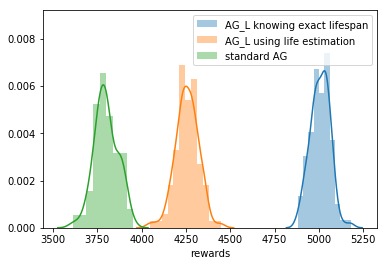

In [18]:
sns.distplot(plt_agl, label='AG_L knowing exact lifespan')
sns.distplot(plt_agl_est, label='AG_L using life estimation')
sns.distplot(plt_ag, label='standard AG')
plt.legend(loc=1)
plt.ylim(top=.0092)
plt.xlabel('rewards')
pass

In [19]:
class UCB_L:
    def __init__(self, records, pool, unborn):
        self.records = records.itertuples()
        self.rewards = 0
        self.alive = [] # heap: (death, id)
        self.pool = copy.deepcopy(pool) # ordered dict of arms
        self.unborn = copy.deepcopy(unborn)
        self.avg_life = 0
        self.X = 0
        
    def update(self, record):
        self.rewards += record.clicked
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        n_seen = len(self.pool) - len(self.unborn)
        self.X = (self.X * (n_seen-1) + record.clicked) / n_seen
    
    def filter_live(self, t):  
        # pop born arms to alive
        while self.unborn and self.pool[self.unborn[-1]].birth<=self.time:
            arm = self.unborn.pop()
            self.pool[arm].s = t
            heapq.heappush(self.alive, (self.pool[arm].death, arm))
        # pop dead arms from alive
        while self.alive:
            death, arm = self.alive[0]
            if death < self.time:
                heapq.heappop(self.alive)    
                dying = self.pool[arm]
                dying.l = t
                n_dead = len(self.pool) - len(self.unborn) - len(self.alive)
                self.avg_life = (self.avg_life* (n_dead-1) + (dying.l-dying.s+1)) / n_dead            
            else:
                break
        return

    def initialize(self, m):
        self.m = m
        i = 0
        while i < m:
            try:
                record = next(self.records) # raise StopIteration
            except StopIteration as si:
                print(si)
                print(record)
                return
            self.time = record.timestamp
            self.filter_live(i)
            if not self.pool[record.id].T: # not played
                self.update(record)
                i += 1
    
    def play(self, n, c=None):
        def score(heap_tuple):
            arm = self.pool[heap_tuple[1]]
            if arm.T:
                T = arm.T
                X = arm.X
            else: # if it's never played, use estimation
                T = 1
                X = self.X
            if not c:
                # if:
                #  not c: not considering remaining life
                # then:
                #  use the original expression that only counts life spent, but not life remaining
                return X + np.sqrt( 2*np.log(self.t - arm.s + 1)/T )
            if c=='vanilla': # vanilla UCB
                return X + np.sqrt( 2*np.log(self.t)/T )
            if not self.avg_life or self.avg_life+arm.s-self.t+1 <= 0:
                # if no estimation or the estimated life length is too small
                # then use 0 as estimated remaining life
                return X
            return X + c*np.log(self.avg_life+arm.s-self.t+1) * np.sqrt(2*np.log(self.t - arm.s+1)/T)
        self.n = n
        for self.t in range(self.m, n):
            while True: # keep trying
                try:
                    record = next(self.records) # raise StopIteration
                except StopIteration as si:
                    print(si)
                    return
                self.time = record.timestamp
                self.filter_live(self.t)
                pick = max(self.alive, key=score)[1]
                if pick == record.id:
                    self.update(record)
                    break

In [17]:
# UCB
def player(i):
    print('player',i,'started')
    start = time.time()
    ucbl = UCB_L(records[i*10000:], pool, unborn)
    ucbl.initialize(25)
    ucbl.play(100000)
    end = time.time()
    print('player:',i,'reward:',ucbl.rewards,'time:', end-start)
    return ucbl.rewards
with Pool(6) as p:
    plt_ucb = p.map(player, [i for i in range(100)])

player 0 started
player 25 started
player 5 started
player 20 started
player 15 started
player 10 started
player: 15 reward: 5075 time: 412.3696093559265 records: 1166346
player 16 started
player: 20 reward: 5200 time: 476.16146087646484 records: 2020028
player 21 started
player: 10 reward: 4994 time: 511.876736164093 records: 1141479
player 11 started
player: 5 reward: 5079 time: 539.4996583461761 records: 1208596
player 6 started
player: 0 reward: 5061 time: 545.3572924137115 records: 923051
player 1 started
player: 25 reward: 5235 time: 744.9955775737762 records: -239342
player 26 started
player: 16 reward: 5206 time: 411.89100670814514 records: 1217490
player 17 started
player: 6 reward: 5010 time: 444.83476185798645 records: 1195145
player 7 started
player: 11 reward: 4983 time: 477.6892833709717 records: 1145026
player 12 started
player: 1 reward: 5076 time: 498.34674286842346 records: 941799
player 2 started
player: 21 reward: 5181 time: 686.2287349700928 records: -195809
player

player: 99 reward: 5266 time: 536.9165897369385 records: -459233


In [23]:
with open('save/plt_ucb','wb') as f:
    pickle.dump(plt_ucb, f)

In [25]:
# vanilla UCB
def player(i):
    print('player',i,'started')
    start = time.time()
    ucbl = UCB_L(records[i*10000:], pool, unborn)
    ucbl.initialize(25)
    ucbl.play(100000, 'vanilla')
    end = time.time()
    print('player:',i,'reward:',ucbl.rewards,'time:', end-start, 'records:', next(ucbl.records).Index-1-i*10000, 'X',ucbl.X, 'avg_life', ucbl.avg_life)
    return ucbl.rewards
with Pool(6) as p:
    plt_ucb_vanilla = p.map(player, [i for i in range(100)])

player 10 started
player 5 started
player 0 started
player 15 started
player 20 started
player 25 started
player: 0 reward: 5076 time: 311.2959213256836 records: 2535296 X 0.04991573113058068 avg_life 40766.35294117647
player 1 started
player: 5 reward: 4999 time: 437.28254103660583 records: 2810906 X 0.01347734389011819 avg_life 35922.083333333336
player 6 started
player: 15 reward: 4984 time: 480.4230329990387 records: 2757491 X 0.11438652461818206 avg_life 37157.256410256414
player 16 started
player: 10 reward: 4990 time: 509.63196849823 records: 2759633 X 0.02247262441272507 avg_life 35917.444444444445
player 11 started
player: 25 reward: 5258 time: 545.9158127307892 records: 3549190 X 0.04947553235511272 avg_life 34492.54716981131
player 26 started
player: 20 reward: 5224 time: 644.9697017669678 records: 3594576 X 0.06535114539896404 avg_life 34603.32075471698
player 21 started
player: 1 reward: 5079 time: 434.95812344551086 records: 2524517 X 0.08161442618610087 avg_life 40692.26

player 67 started
player: 80 reward: 5184 time: 614.8496854305267 records: 3242308 X 0.02285652638915882 avg_life 33465.82142857143
player 81 started
player: 62 reward: 5226 time: 719.2384080886841 records: 3364395 X 0.04155221579629958 avg_life 33245.62962962963
player 63 started
player: 85 reward: 5274 time: 536.1605558395386 records: 3187123 X 0.042924463317194794 avg_life 33559.89285714286
player 86 started
player: 71 reward: 5119 time: 611.7177546024323 records: 3319350 X 0.02898920056143059 avg_life 33632.857142857145
player 72 started
player: 76 reward: 5169 time: 676.100804567337 records: 3288553 X 0.043231339672520415 avg_life 33456.37499999999
player 77 started
player: 86 reward: 5088 time: 547.6951625347137 records: 3284922 X 0.05410295534576298 avg_life 33169.40350877193
player 87 started
player: 63 reward: 5163 time: 596.5061302185059 records: 3351227 X 0.06862766926648071 avg_life 33286.833333333336
player 64 started
player: 67 reward: 5203 time: 715.3436598777771 records

In [26]:
with open('save/plt_ucb_vanilla', 'wb') as f:
    pickle.dump(plt_ucb_vanilla, f)

In [20]:
# UCB_L using life estimation
def player(i):
    print('player',i,'started')
    start = time.time()
    ucbl = UCB_L(records[i*10000:], pool, unborn)
    ucbl.initialize(25)
    ucbl.play(100000, .011)
    end = time.time()
    print('player:',i,'reward:',ucbl.rewards,'time:', end-start, 'records:', next(ucbl.records).Index-1-i*10000, 'X',ucbl.X, 'avg_life', ucbl.avg_life)
    return ucbl.rewards
with Pool(6) as p:
    plt_ucbl_est = p.map(player, [i for i in range(100)])

player 0 started
player 5 started
player 15 started
player 20 started
player 10 started
player 25 started
player: 15 reward: 7323 time: 258.31602716445923 records: 2737483 X 0.11051895556770036 avg_life 36137.32432432433
player 16 started
player: 10 reward: 6952 time: 292.41910886764526 records: 2753146 X 0.08627174791767528 avg_life 35867.166666666664
player 11 started
player: 25 reward: 8215 time: 297.7425465583801 records: 3389708 X 0.10679673267945682 avg_life 34315.96078431373
player 26 started
player: 5 reward: 7311 time: 352.43462467193604 records: 2776494 X 0.07284746768091878 avg_life 36256.305555555555
player 6 started
player: 0 reward: 6494 time: 357.190132856369 records: 2506980 X 0.09595839348279968 avg_life 41310.94117647059
player 1 started
player: 20 reward: 8108 time: 404.7822644710541 records: 3429918 X 0.11206801484614545 avg_life 34387.19607843137
player 21 started
player: 16 reward: 7351 time: 255.84310030937195 records: 2787154 X 0.16596199360968808 avg_life 35961

player 71 started
player: 80 reward: 8612 time: 306.5451958179474 records: 3120463 X 0.11094380044224739 avg_life 32927.67924528302
player 81 started
player: 59 reward: 8414 time: 366.10315680503845 records: 3197790 X 0.07887805467214334 avg_life 34166.69811320755
player 85 started
player: 75 reward: 8611 time: 456.5695743560791 records: 3170463 X 0.11094380044224739 avg_life 32927.67924528302
player 76 started
player: 61 reward: 8624 time: 419.0737376213074 records: 3214927 X 0.12455992740818832 avg_life 33787.50943396227
player 62 started
player: 66 reward: 8485 time: 439.3501226902008 records: 3143711 X 0.12455233655729914 avg_life 34049.339622641506
player 67 started
player: 71 reward: 8589 time: 402.94339895248413 records: 3170299 X 0.09874338460929491 avg_life 33157.20754716981
player 72 started
player: 85 reward: 8578 time: 372.4316942691803 records: 3064854 X 0.05968555261481844 avg_life 32935.56603773585
player 86 started
player: 81 reward: 8611 time: 499.60178804397583 record

In [21]:
with open('save/plt_ucbl_est', 'wb') as f:
    pickle.dump(plt_ucbl_est,f)

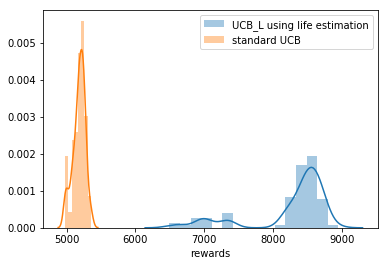

In [6]:
sns.distplot(plt_ucbl_est, label='UCB_L using life estimation')
#sns.distplot(plt_ucb, label='UCB: considering spent life')
sns.distplot(plt_ucb_vanilla, label='standard UCB')
plt.legend()
plt.xlabel('rewards')
pass